In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from bus_pedestrian_crowding import Model
from multiprocessing import Pool, Manager
import itertools
import pandas as pd
import csv
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from PIL import Image

## Nagel-Schreckenberg Model
The Nagel-Schreckenberg is a cellular automata model of traffic that models vehicles using two states: position ($x$) and velocity ($v$). Since it is a cellular automata, these states are discretized. The system then evolves through 4 basic rules:

1. Acceleration: $v_{t_1} \gets \min(v_t + 1, v_\textrm{max})$
2. Deceleration: $v_{t+1} \gets \min(\Delta x,  v_{t+1})$
3. Random Slowdown: $v_{t+1} \gets \max(v_{t+1}-1,0) \textrm{ with prob. } p_\text{slow}$
4. Movement: $x_{t+1} \gets x_t + v_{t+1}\Delta t $

In [2]:
class Vehicle:
    marker = 1
    lane = 0

    def __init__(self, Model, pos, vel, p_slow, **kwargs):
        self.pos = pos
        self.p_slow = p_slow
        self.vel = vel
        self.vmax = Model.vmax
        self.road = Model.road
        self.Model = Model
        self.id = Model.generate_id()

    def accelerate(self):
        self.vel = min(self.vel+1, self.vmax)

    def decelerate(self):
        self.vel = min(self.vel, self.headway(self.lane))

    def random_slow(self):
        if (np.random.random() < self.p_slow):
            self.vel = max(self.vel-1, 0)

    def movement(self):
        self.remove()
        self.pos += self.vel  # the actual rule
        if self.Model.is_periodic:
            self.pos %= self.Model.roadlength
        self.place()

    def headway(self, lane):
        headwaycount = 0
        _pos = self.pos+1
        if self.Model.is_periodic:
            _pos %= self.Model.roadlength
        while (self.road[lane, _pos] == 0) and (headwaycount < (self.vmax*2)):
            _pos += 1
            if self.Model.is_periodic:
                _pos %= self.Model.roadlength
            headwaycount += 1
        return headwaycount

    def place(self):
        self.road[self.lane, self.pos] = self.id

    def remove(self):
        self.road[self.lane, self.pos] = 0


class NaSch:
    id_counter = 0

    def __init__(self, roadlength, vmax, density, p_slow, num_lanes=1, is_periodic=True):
        self.roadlength = roadlength
        self.num_lanes = num_lanes
        self.vehicle_array = []
        self.road = np.zeros((num_lanes, roadlength), dtype=int)
        self.vmax = vmax
        self.is_periodic = is_periodic
        self.p_slow = p_slow

        if self.is_periodic:  # initialize vehicles now since no inflows
            num_vehicles = int(density*roadlength*num_lanes)
            self.place_vehicle_type(Vehicle, num_vehicles)

    def generate_id(self):
        self.id_counter = self.id_counter + 1
        return self.id_counter

    def place_vehicle_type(self, veh_type, number):
        for i in range(number):
            pos = 0
            lane = self.num_lanes-1
            while not self.place_check(pos, lane):
                pos = np.random.randint(self.roadlength)
                lane = np.random.randint(self.num_lanes)
            vehicle = veh_type(Model=self, pos=pos, lane=lane,
                               vel=self.vmax, p_slow=self.p_slow)
            self.vehicle_array.append(vehicle)
            vehicle.place()

    def place_check(self, pos, lane):
        return False if self.road[lane, pos] else True

    def timestep_parallel(self):
        np.random.shuffle(self.vehicle_array)
        reached_end = []
        for i, vehicle in enumerate(self.vehicle_array):
            vehicle.accelerate()

        for i, vehicle in enumerate(self.vehicle_array):

            vehicle.decelerate()
            vehicle.random_slow()

        for i, vehicle in enumerate(self.vehicle_array):

            vehicle.movement()

            if vehicle.pos >= (self.roadlength-self.vmax-1):
                reached_end.append(i)
        if not self.is_periodic:
            self.clear(reached_end)

    def timestep(self):
        np.random.shuffle(self.vehicle_array)
        reached_end = []

        for i, vehicle in enumerate(self.vehicle_array):
            # core rules
            vehicle.accelerate()
            vehicle.decelerate()
            vehicle.random_slow()
            vehicle.movement()

            if vehicle.pos >= (self.roadlength-self.vmax-1):
                reached_end.append(i)

    # define metrics
    def throughput(self):
        return 1.*sum([i.vel for i in self.vehicle_array])/self.roadlength/self.num_lanes

    def get_density(self):
        count = 0
        for i in range(len(self.road)):
            for j in range(len(self.road[0])):
                if self.road[i, j] != 0:
                    count += 1
        return count/self.road.size

    def get_road(self):
        road = np.zeros((self.num_lanes, self.roadlength), dtype=np.int)
        for veh in self.vehicle_array:
            road[veh.lane, veh.pos] = veh.marker
        return road


### Visualization

In [3]:
roadlength = 40
num_lanes = 1
timesteps = 200
# xscale = 5 # frames to interpolate
xscale = 1  # frames to interpolate
yscale = 2

model = NaSch(roadlength, vmax=5, is_periodic=True, density=0.2, p_slow=0.1)
# model = Model(roadlength, num_lanes, vmax=5, alpha=0, frac_bus=0, density=0.2, p_slow=0.1, is_periodic=True)

# generate simulation data
states = []
for i in range(timesteps):
    for j in np.arange(0, 1, 1/xscale):
        # set np.nan for values to be interpolated
        [states.append({'vel': veh.pos*xscale if i == 0 and j == 0 else veh.vel*xscale if j == 0 else np.nan,
                        'lane': veh.lane*yscale,
                        'id': veh.id, 'type': veh.marker, 'time': i+j}) for veh in model.vehicle_array]
    model.timestep_parallel()

df = pd.DataFrame(states)
df['pos'] = df.groupby('id')['vel'].cumsum()
df = df.groupby('id').apply(lambda group: group.interpolate(
    method='linear'))  # this is just for smoother animations
df['pos'] = (df['pos'] % (roadlength*xscale)).astype('int')
df['lane'] = df['lane'].astype('int')
time_grouping = df.groupby('time')
time_indices = df['time'].unique()


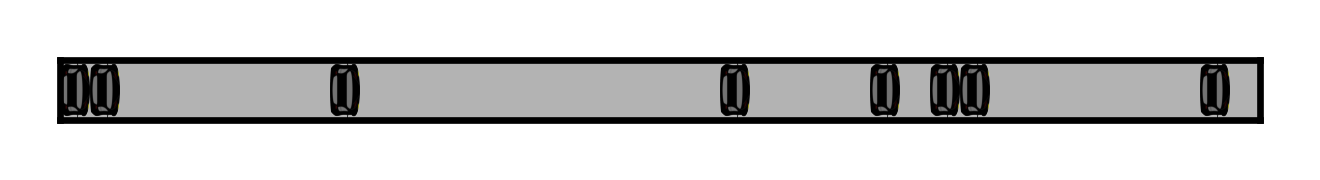

In [4]:
fig, ax = plt.subplots(1, figsize=(
    roadlength*xscale/20, num_lanes*yscale/20), dpi=600)
ax.set_facecolor('0.7')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, roadlength*xscale)
ax.set_ylim(0, num_lanes*yscale)
ax.tick_params(labelcolor='none', top=False,
               bottom=False, left=False, right=False)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)


array = time_grouping.get_group(0)[['pos', 'lane', 'type']].values
car_im = Image.open('car.png')
bus_im = Image.open('bus.png')
veh_icons = [car_im, bus_im]

# init
ims = []  # holds each vehicle drawn at the correct position
for x, y, veh_type in array:
    ims.append(ax.imshow(
        veh_icons[int(veh_type-1)], extent=(x, x+xscale, y, y+yscale), origin='lower'))


# animation function.  This is called sequentially
def animate(i):
    array = time_grouping.get_group(time_indices[i])[
        ['pos', 'lane', 'type']].values
    for i, im in enumerate(ims):  # redraw vehicles
        x, y, icon = array[i]
        im.set_data(veh_icons[icon-1])
        im.set_extent((x, x+xscale, y, y+yscale))
    return ims


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=timesteps*xscale, interval=30, blit=True)
# HTML(anim.to_html5_video())
# anim.save("anim.mp4")


In [5]:
sim_time = 1000
trans_time = 100
num_lanes = 1


def simulate(density):
    print(f'simulating density: {density:.2f}')
    roadlength = 100
    vmax = 5
    density = density
    p_slow = 0.1
    is_periodic = True
    throughputs = []
    speeds = []
#     road = Model(roadlength, 1, vmax, 0,
#                     0, density, p_slow, is_periodic)
    road = NaSch(roadlength, vmax, density, p_slow,
                 num_lanes=1, is_periodic=True)
    for t in range(sim_time+trans_time):
        road.timestep_parallel()
#         road.timestep()
        if t >= trans_time:
            throughputs.append(road.throughput())
            speeds.append([veh.vel for veh in road.vehicle_array])
    res = {"throughput": np.mean(throughputs),
           "density": road.get_density(),
           "speed": np.mean(speeds)}
    return res


densities = np.arange(0.05, 0.5, 0.05)

bus_fractions = np.linspace(0, 1/num_lanes, 11)

with open('dataset.csv', 'w') as f:
    writer = csv.writer(f)
    lines = 0
    for density in densities:
        result = simulate(density)
        if lines == 0:
            writer.writerow(result.keys())
            lines += 1
        writer.writerow(result.values())


simulating density: 0.05
simulating density: 0.10
simulating density: 0.15
simulating density: 0.20
simulating density: 0.25
simulating density: 0.30
simulating density: 0.35
simulating density: 0.40
simulating density: 0.45


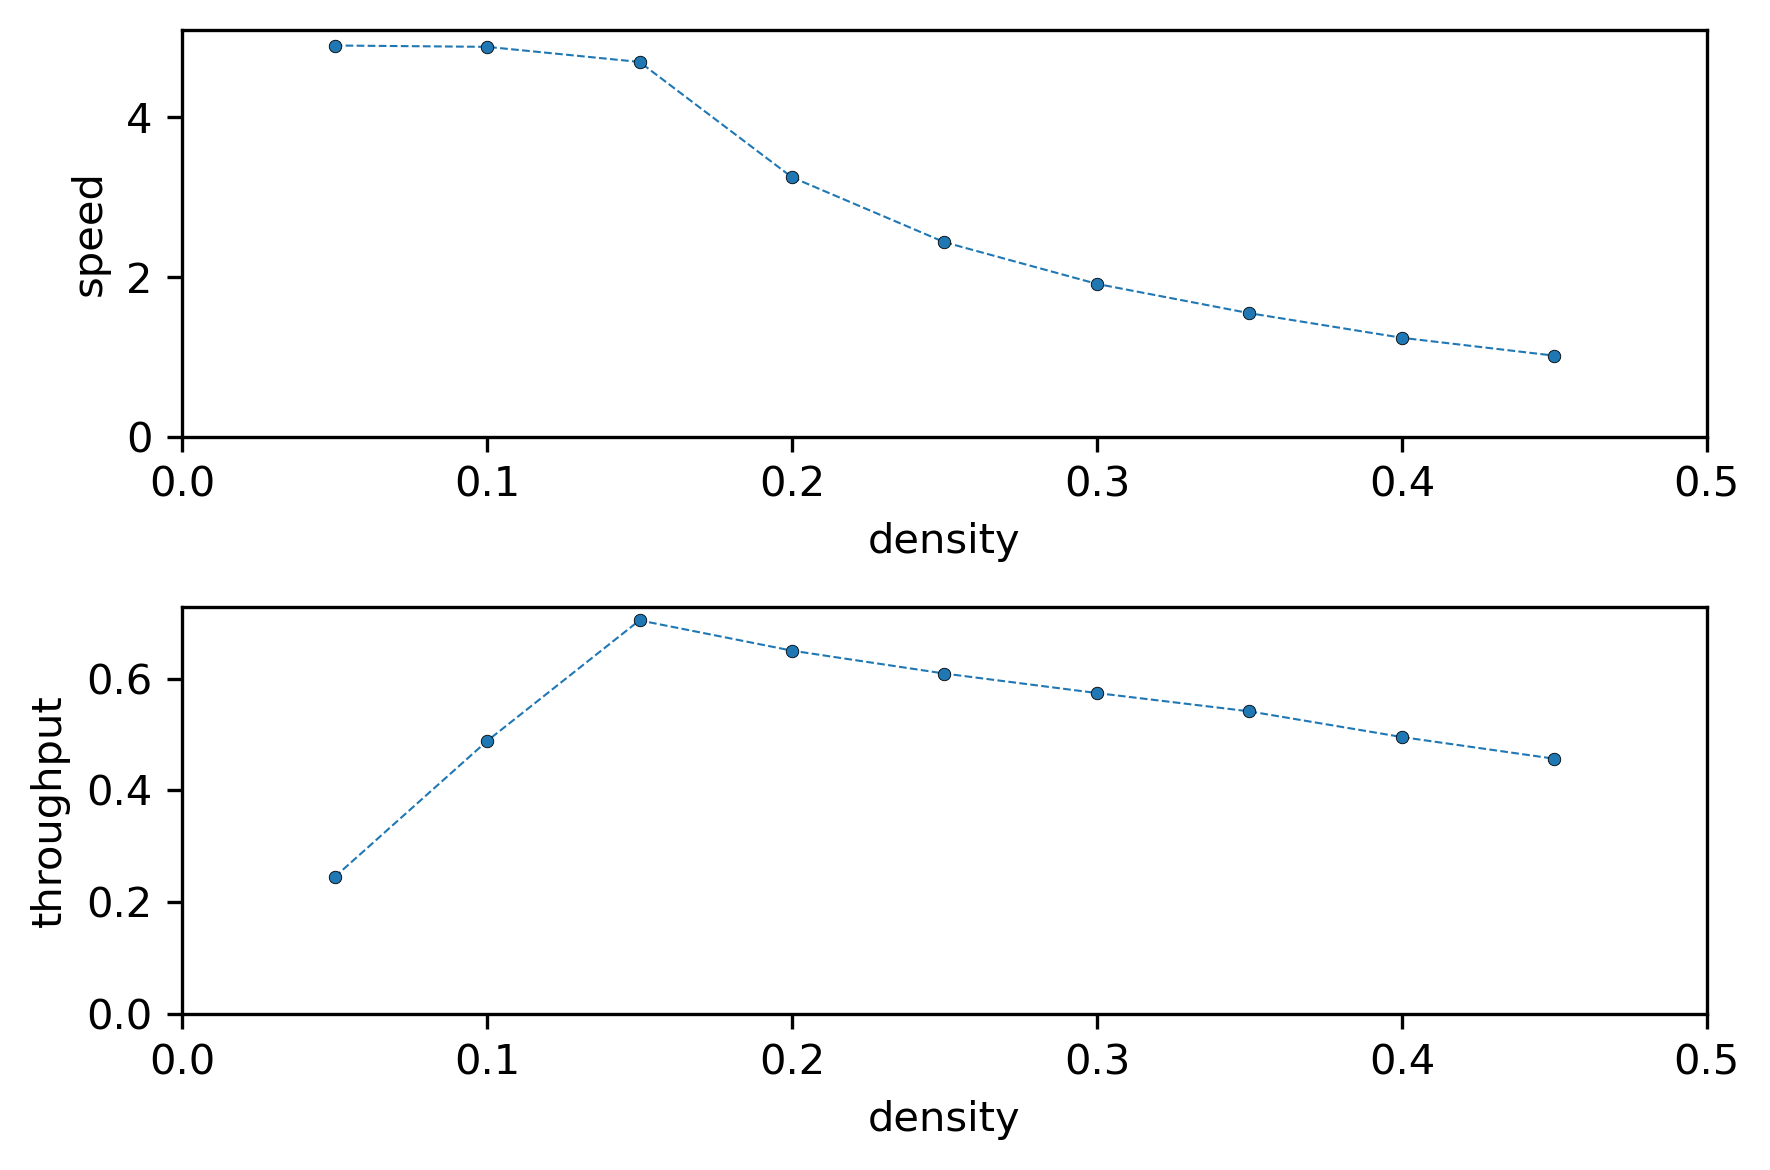

In [6]:
df = pd.read_csv("dataset.csv")

fig, [ax1, ax2] = plt.subplots(2, 1, dpi=300, sharey=False)

ax1.plot(df["density"], df["throughput"]/df["density"],
         marker='o', ms=3, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.2,
         ls='--')

ax1.set_xlabel(r"density")
ax1.set_ylabel(r"speed")
ax1.set_ylim(bottom=0)
ax1.set_xlim(0, 0.5)

ax2.plot(df["density"], df["throughput"],
         marker='o', ms=3, linewidth=0.5, markeredgecolor='k', markeredgewidth=0.2,
         ls='--')

ax2.set_xlabel(r"density")
ax2.set_ylabel(r"throughput")
ax2.set_ylim(bottom=0)
ax2.set_xlim(0, 0.5)

fig.tight_layout()


## References
1. https://github.com/temetski/PedestrianCrowding
2. K. Nagel and M. Schreckenberg, J. Phys. I 2, 2221 (1992).
